In [2]:
from fastai.vision.all import *
from fastbook import *
import pandas as pd

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1, output_size):
        super(SimpleNN, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size1)
        self.ReLU = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size1,output_size)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.ReLU(x)
        x = self.linear2(x)
        return x

def validate_epoch(model, valid_dl):
        accs = [batch_accuracy(model(x),y) for x,y in valid_dl]
        return round(torch.stack(accs).mean().item(), 4)
    
def batch_accuracy(x, y):
        preds = softmax(x)
        predicted_value = torch.argmax(preds, dim=1)
        trgts = y.flatten()
        bools = predicted_value == trgts
        acc = bools.to(torch.float).mean()
        return acc

def softmax(preds):
    preds = preds-torch.max(preds)
    return torch.exp(preds)/torch.sum(torch.exp(preds), dim=1).unsqueeze(1)

def cross_entropy_loss(preds, trgt):
        soft = softmax(preds)
        one_hot = torch.zeros(trgt.shape[0], soft.shape[1])
        for i in range(one_hot.size(0)):
            index = trgt[i, 0].item()
            one_hot[i, int(index)] = 1
        loss = -torch.sum(torch.log(soft)*one_hot)
        return loss

def stacker(df):
    image_list = [torch.tensor(df.iloc[img].values) for img in range(len(df))]
    stacked = torch.stack(image_list).float()/255
    return stacked

def loader(data, labels):
    zipped_data = list(zip(torch.cat(data).view(-1, 28*28),tensor(labels).unsqueeze(1)))
    return DataLoader(zipped_data, batch_size=256, shuffle=True)

def imgs(train, test):

    testing = [stacker(test[test["label"] == i].iloc[:, 1:785]) for i in range(10)]
    validation = [stacker(train[train["label"] == i].iloc[0:(round(len(train[train["label"] == i])*.2)+1),1:785].reset_index().drop(labels ="index", axis=1)) for i in range(10)]
    training = [stacker(train[train["label"] == i].iloc[round(len(train[train["label"] == i])*.2)+1:,1:785].reset_index().drop(labels ="index", axis=1)) for i in range(10)]

    testing_labels = sum([[i]*len(testing[i]) for i in range(10)],[])
    training_labels = sum([[i]*len(training[i]) for i in range(10)],[])
    validation_labels = sum([[i]*len(validation[i]) for i in range(10)],[])
    return loader(testing, testing_labels), loader(validation, validation_labels), loader(training, training_labels)



#testing, training, validation = imgs(train, test)

In [4]:
## Creating a benchmark
train = pd.read_csv("/Users/koto/build/fast/MNIST/mnist_train.csv")
test = pd.read_csv("/Users/koto/build/fast/MNIST/mnist_test.csv")
def stacker(df):
    image_list = [torch.tensor(df.iloc[img].values) for img in range(len(df))]
    stacked = torch.stack(image_list).float()/255
    return stacked
testing = [stacker(test[test["label"] == i].iloc[:, 1:785]) for i in range(10)]
validation = [stacker(train[train["label"] == i].iloc[0:(round(len(train[train["label"] == i])*.2)+1),1:785].reset_index().drop(labels ="index", axis=1)) for i in range(10)]
training = [stacker(train[train["label"] == i].iloc[round(len(train[train["label"] == i])*.2)+1:,1:785].reset_index().drop(labels ="index", axis=1)) for i in range(10)]

In [7]:
avg_imgs = [training[i].mean(dim=0)for i in range(10)]
avg_imgs_tensor = torch.stack(avg_imgs)  # Shape: [10, feature_dim]

accuracy_vals = []

for j in range(10):
    # Extract all test images for class j
    validation_images = validation[j]  # Shape: [num_samples, feature_dim]

    # Compute absolute difference using broadcasting
    # The shape of diffs will be [num_samples, 10, feature_dim]
    diffs = (validation_images[:, None, :] - avg_imgs_tensor[None, :, :]).abs()

    # Calculate the mean difference for each test image against each class average
    mean_diffs = diffs.mean(dim=2)  # Shape: [num_samples, 10]

    # Find the class with the smallest mean difference for each test image
    preds = mean_diffs.argmin(dim=1)  # Shape: [num_samples]

    # Calculate accuracy for class j
    correct_preds = (preds == j).float()  # Shape: [num_samples]
    accuracy = correct_preds.mean().item()  # Scalar value

    accuracy_vals.append(accuracy)

# Calculate the overall accuracy
benchmark_accuracy = sum(accuracy_vals) / len(accuracy_vals)

benchmark_accuracy

0.6424992471933365

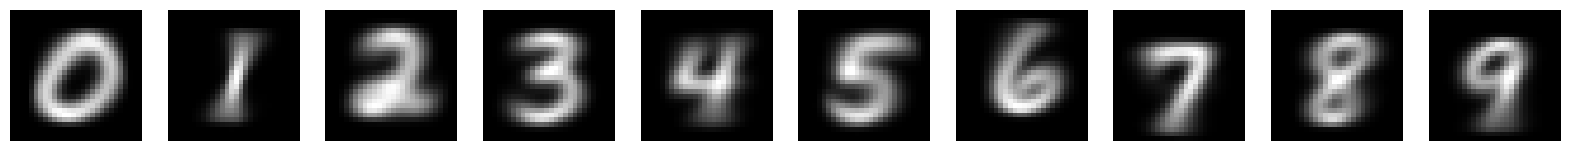

In [6]:
import matplotlib.pyplot as plt
displ_avg_imgs = [testing[i].mean(dim=0).numpy().reshape(1,28,28) for i in range(10)]
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, img in enumerate(avg_imgs):
    ax = axes[i]
    # Since the image is stored as [28, 28, 1], we squeeze it to [28, 28] for display
    ax.imshow(img.reshape(1,28,28).squeeze(), cmap='gray')  # Use cmap='gray' for grayscale images
    ax.axis('off')  # Turn off axis to only show the image

plt.show()


In [11]:
epochs = 1000
lr = 0.0001
model = SimpleNN(28*28, 30, 10)

opt = SGD(model.parameters(), lr)

In [12]:
from IPython.display import display, clear_output

for i in range(epochs):
    for x,y in training_data:
        preds = model(x)
        loss = cross_entropy_loss(preds, y)
        loss.backward()
        for param in model.parameters():
            param.data -= lr*param.grad.data
            param.grad = None
    if loss < 1.5:
        break
    acc = torch.stack([batch_accuracy(softmax(model(x)), y) for x,y in validation_data]).mean()
    clear_output(wait=True)  
    print(f"Loss: {loss} \n model accuracy: {acc*100:.0f}%")
    time.sleep(.01)

Loss: 5.380589008331299 
 model accuracy: 96%
